In [ ]:
#!/usr/bin/env python

# Copyright (c) 2020, Mahboob Karimian (mahboob.karimiyan{at}gmail.com)
# All rights reserved.
#
# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:
#   * Redistributions of source code must retain the above copyright notice,
#     this list of conditions and the following disclaimer.
#   * Redistributions in binary form must reproduce the above copyright
#     notice, this list of conditions and the following disclaimer in the
#     documentation and/or other materials provided with the distribution.
#   * Neither the name of the owner nor the names of its contributors may be
#     used to endorse or promote products derived from this software without
#     specific prior written permission.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE
# ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT OWNER OR CONTRIBUTORS BE
# LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR
# CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF
# SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS
# INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN
# CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE)
# ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE
# POSSIBILITY OF SUCH DAMAGE.

In [1]:
from bs4 import BeautifulSoup
import subprocess
import re
import networkx as nx
import netgraph
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

In [2]:
"""
# ADD "global IPv6 address" OF YOUR BORDER ROUTER to br_global_ip
# EXAMPLE:
# br_global_ip = "fd00::302:304:506:708"
br_global_ip = "fd00::302:304:506:708"
subprocess.call(f"wget -O index.html http://[{br_global_ip}]", shell=True)
"""

'\n# ADD\xa0"global IPv6 address" OF\xa0YOUR BORDER\xa0ROUTER to br_global_ip\n# EXAMPLE:\n# br_global_ip = "fd00::302:304:506:708"\nbr_global_ip = "fd00::302:304:506:708"\nsubprocess.call(f"wget -O index.html http://[{br_global_ip}]", shell=True)\n'

In [3]:
IpList = []
root = 'BR'
# Open and parse html
with open('index.html', 'r') as f:
    contents = f.read()
    soup = BeautifulSoup(contents, 'lxml')
    llsList = soup.find_all('body')
    for l in llsList:
        # Get all list tags in html
        ulList = l.find_all('li')
        for li in ulList:
            if "via" in li.text:
                # Routing table as tuples
                via = re.sub('\)','', li.text.split(' ')[2].replace('fe80', 'fd00'))
                dst = re.sub(r'/\w+','', li.text.split(' ')[0])
                if via != dst: IpList.append((dst, via))
            else:
                # BR Neighbors
                nbr = li.text.replace('fe80', 'fd00')
                IpList.append((nbr, root))

# Remove duplicates from list using set
IpList = list(set(IpList))

In [4]:
# Generating Directed graph
Mesh = nx.DiGraph()
# All destinations are nodes, get them from IpList
dst = [dst[0] for dst in IpList]
Mesh.add_nodes_from(dst)
# All elements in IpList are edges
Mesh.add_edges_from(IpList)
# Add labels, we take the last 2 sections of the ipv6 address
lblist = [':'.join(lbl.split(':')[-2:]) for lbl in dst]
lbdict = dict(zip(dst, lblist))
lbdict['BR'] = 'BR'
#print(Mesh.nodes())
#print(Mesh.edges())
#print(dst)

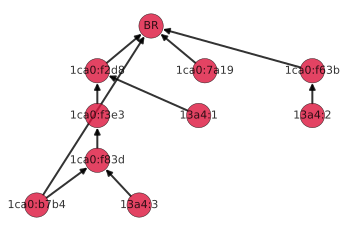

In [5]:
pos = nx.nx_agraph.graphviz_layout(Mesh, prog="dot", root='BR')
options = {
    'node_color': 'crimson',
    'node_shape': 'o',
    "edgecolors": 'k',
    'linewidths': 0.5,
    'alpha': 0.8,
    'node_size': 600,
    'edge_color':'k',
    'width': 2,
    'arrowstyle': '-|>',
    'arrowsize': 12,
    'font_size': 11,
    'labels': lbdict
}
nx.draw_networkx(Mesh, pos, arrows=True, **options)
G = nx.DiGraph(directed=True)
plt.gca().invert_yaxis()
plt.gca().set_axis_off()
plt.show()

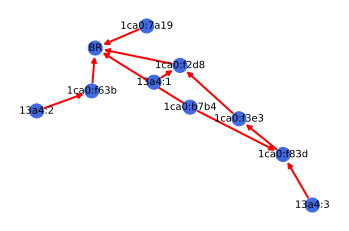

In [6]:
pos = nx.spring_layout(Mesh)
#pos = nx.nx_agraph.graphviz_layout(Mesh, prog="dot", root=root_node)
nx.draw_networkx_nodes(Mesh, pos, node_color='royalblue', alpha = 1, node_size = 200)
nx.draw_networkx_edges(Mesh, pos, edge_color='r', width = 2, arrows=True)
nx.draw_networkx_labels(Mesh, pos, labels = lbdict, font_size = 10)
plt.gca().set_axis_off()
plt.show()

In [7]:
%pwd

'/home/mahboob/test/html_parser'

In [8]:
import json
import flask
from networkx.readwrite import json_graph

# write json formatted data
d = json_graph.node_link_data(Mesh)  # node-link format to serialize
# add degree of each node
for dict_i in d['nodes']:
  dict_i['degree'] = str(dict(Mesh.degree()).get(dict_i.get('id')))
# write json
json.dump(d, open("force/force.json", "w"))
print("Wrote node-link JSON data to force/force.json")
print(d)

Wrote node-link JSON data to force/force.json
{'directed': True, 'multigraph': False, 'graph': {}, 'nodes': [{'id': 'fd00::212:4b00:1ca0:f63b', 'degree': '2'}, {'id': 'fd00::212:4b00:1ca0:b7b4', 'degree': '2'}, {'id': 'fd00::212:4b00:1ca0:f83d', 'degree': '3'}, {'id': 'fd00::212:4b00:13a4:1', 'degree': '1'}, {'id': 'fd00::212:4b00:1ca0:f3e3', 'degree': '2'}, {'id': 'fd00::212:4b00:13a4:3', 'degree': '1'}, {'id': 'fd00::212:4b00:1ca0:7a19', 'degree': '1'}, {'id': 'fd00::212:4b00:13a4:2', 'degree': '1'}, {'id': 'fd00::212:4b00:1ca0:f2d8', 'degree': '3'}, {'id': 'BR', 'degree': '4'}], 'links': [{'source': 'fd00::212:4b00:1ca0:f63b', 'target': 'BR'}, {'source': 'fd00::212:4b00:1ca0:b7b4', 'target': 'fd00::212:4b00:1ca0:f83d'}, {'source': 'fd00::212:4b00:1ca0:b7b4', 'target': 'BR'}, {'source': 'fd00::212:4b00:1ca0:f83d', 'target': 'fd00::212:4b00:1ca0:f3e3'}, {'source': 'fd00::212:4b00:13a4:1', 'target': 'fd00::212:4b00:1ca0:f2d8'}, {'source': 'fd00::212:4b00:1ca0:f3e3', 'target': 'fd00::21

In [ ]:
# Serve the file over http to allow for cross origin requests
app = flask.Flask(__name__, static_folder="force")


@app.route("/")
def static_proxy():
    return app.send_static_file("force.html")


print("\nGo to http://localhost:8000 to see the example\n")
app.run(port=8001)


Go to http://localhost:8000 to see the example

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8001/ (Press CTRL+C to quit)
127.0.0.1 - - [27/Dec/2020 12:29:23] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 12:29:23] "GET /force/force.css HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 12:29:23] "GET /force/force.js HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 12:29:23] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [27/Dec/2020 12:29:28] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 12:29:28] "GET /force/force.css HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 12:29:28] "GET /force/force.js HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 12:29:28] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [27/Dec/2020 12:41:42] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 12:41:42] "GET /force/force.css HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 12:41:42] "GET /force/force.js HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 12:41:42] "GET /force/force.json HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 12:41:42] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [27/Dec/20

127.0.0.1 - - [27/Dec/2020 13:13:30] "GET /force/force.js HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 13:13:30] "GET /force/force.json HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 13:13:30] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [27/Dec/2020 13:15:53] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 13:15:53] "GET /force/force.css HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 13:15:53] "GET /force/force.js HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 13:15:54] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [27/Dec/2020 13:23:34] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 13:23:34] "GET /force/force.css HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 13:23:34] "GET /force/force.js HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 13:23:34] "GET /force/force.json HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 13:23:34] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [27/Dec/2020 13:23:59] "GET / HTTP/1.1" 304 -
127.0.0.1 - - [27/Dec/2020 13:25:41] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2

127.0.0.1 - - [27/Dec/2020 13:47:19] "GET / HTTP/1.1" 304 -
127.0.0.1 - - [27/Dec/2020 13:48:55] "GET / HTTP/1.1" 304 -
127.0.0.1 - - [27/Dec/2020 13:49:28] "GET / HTTP/1.1" 304 -
127.0.0.1 - - [27/Dec/2020 13:52:26] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 13:52:26] "GET /force/force.js HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 13:52:26] "GET /force/force.css HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 13:52:26] "GET /force/force.json HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 13:52:26] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [27/Dec/2020 13:53:09] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 13:53:09] "GET /force/force.css HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 13:53:09] "GET /force/force.js HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 13:53:10] "GET /force/force.json HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 13:53:10] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [27/Dec/2020 13:53:31] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 13:53:31] "GET /force

127.0.0.1 - - [27/Dec/2020 14:16:14] "GET /force/force.json HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 14:16:14] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [27/Dec/2020 14:17:47] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 14:17:47] "GET /force/force.css HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 14:17:47] "GET /force/force.js HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 14:17:47] "GET /force/force.json HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 14:17:47] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [27/Dec/2020 14:17:59] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 14:17:59] "GET /force/force.css HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 14:17:59] "GET /force/force.js HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 14:17:59] "GET /force/force.json HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 14:17:59] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [27/Dec/2020 14:19:07] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 14:19:07] "GET /force/force.css HTTP/1.1" 200 -
127.0.

127.0.0.1 - - [27/Dec/2020 14:37:13] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 14:37:13] "GET /force/force.css HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 14:37:13] "GET /force/force.js HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 14:37:13] "GET /force/force.json HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 14:37:13] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [27/Dec/2020 14:39:51] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 14:39:51] "GET /force/force.css HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 14:39:51] "GET /force/force.js HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 14:39:52] "GET /force/force.json HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 14:39:52] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [27/Dec/2020 14:42:34] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 14:42:34] "GET /force/force.css HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 14:42:34] "GET /force/force.js HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 14:42:35] "GET /force/force.json HTTP/1.1" 200 -
127